# Arima 9:1

In [2]:
pip install pmdarima

In [3]:
# Thư viện
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Đọc file
df = pd.read_excel('eth_processed_data.xlsx')

In [5]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1914,2024-05-27,3826.127197,3973.556396,3821.930420,3892.006836,3892.006836,18949181813
1915,2024-05-28,3892.096924,3924.895752,3771.213867,3840.256348,3840.256348,19846044324
1916,2024-05-29,3840.235107,3880.648438,3742.041260,3763.196533,3763.196533,17411416736
1917,2024-05-30,3763.357666,3823.643311,3702.263672,3746.849609,3746.849609,15065849797


In [7]:
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra(9:1)
# Kích thước tập dữ liệu "Close"(9:1)
train_size = int(0.9*len(time_series_Close))
# Giá trị tập từ liệu "Close" (9:1)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:]
# Lấy index (9:1)
index_train_data = train_data.index
index_test_data = test_data.index
last_index = index_test_data.max()

In [ ]:
auto_arima(train_data, start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=9.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=21256.613, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=20697.073, Time=2.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=21250.205, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=20503.528, Time=6.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=20.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=20510.954, Time=2.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=20504.825, Time=4.53 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=20501.181, Time=4.92 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=20695.679, Time=1.69 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=21.46 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=7.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : 

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [8]:
# Huấn luyện model
model = ARIMA(train_data, order=(1,1,1))
fit_model= model.fit()
# Prediction trên tập kiểm tra
predictions = fit_model.forecast(steps=len(test_data))
# Dự đoán 30/60/90
forecast_90 = fit_model.forecast(steps=90)

In [9]:
# Đưa dựa đoán vào index
time_series_Close_90 = df['Close'].copy()
time_series_Close_90 = pd.concat([time_series_Close_90, forecast_90])
forecast_90 = time_series_Close_90.iloc[-90:]
forecast_90.index = range(last_index+1, last_index+91)
forecast_90

1919    1943.157102
1920    1942.162462
1921    1942.324901
1922    1942.298372
1923    1942.302705
           ...     
2004    1942.302097
2005    1942.302097
2006    1942.302097
2007    1942.302097
2008    1942.302097
Length: 90, dtype: float64

In [10]:
# Xác định kích thước mỗi phần
split_size = len(forecast_90) // 3
forecast_values_30day = forecast_90[:split_size]
forecast_values_60day = forecast_90[split_size:2*split_size]
forecast_values_90day = forecast_90[2*split_size:]

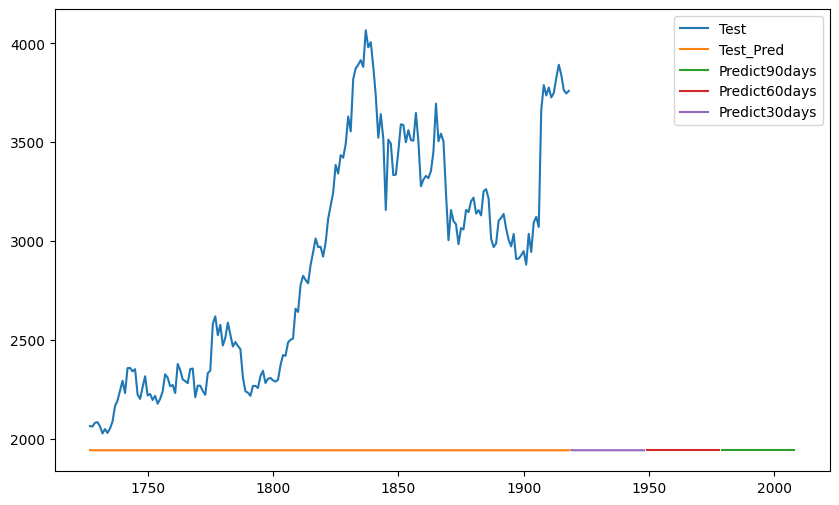

In [11]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
plt.plot(test_data.index,test_data, label='Test')
plt.plot( predictions, label='Test_Pred')
plt.plot(forecast_values_90day.index, forecast_values_90day,label='Predict90days')
plt.plot(forecast_values_60day.index, forecast_values_60day,label='Predict60days')
plt.plot(forecast_values_30day.index, forecast_values_30day, label='Predict30days')
plt.legend()
plt.show()

In [12]:
# Tính toán RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
# Tính toán MAE
mae = mean_absolute_error(test_data, predictions)
# Tính toán MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data, predictions)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 1107.2303403462536
MAE: 944.6144898912113
MAPE: 29.963036512276727
